# Boro Player Predictions - Current Market Value

## 0. Setup

In [1]:
import os
import numpy as np
import pandas as pd

## 1. Problem Definition

The aim of this project is to see if we can use data on players at Middlesbrough Football Club to make preditions about the player's and the team's current and future performance.

"Performance" could be measured in many different ways: Results on the pitch, market value, fan popularity, churn, ...

## 2. Data Understanding

The first part of the data we'll look at is some general information on players, including their market value, as taken from Transfermarkt

In [99]:
dir_tmk_cnt = "../data/raw/tmk/tmk_cnt/"
data_list = []
for file in os.listdir(dir_tmk_cnt):
    filepath = os.path.join(dir_tmk_cnt, file)
    print(filepath)
    tmp = pd.read_csv(filepath, encoding='latin-1', header=0, 
                      names=["Shirt number", "Position", "Name", "Date of birth", "Nationality",
                            "Height", "Foot", "Joined", "Signed from", "Contract expires",
                            "Market value"])
    tmp["Season"] = file.split(".")[0].split("_")[-1]
    data_list.append(tmp)

tmk_df = pd.concat(data_list, axis=0, sort=False, ignore_index=True)

tmk_df["Name"].fillna(method="bfill", inplace=True)

tmk_df["Position"] = tmk_df.Name.shift(-1)
tmk_df.loc[tmk_df.Position == tmk_df.Name, "Position"] = tmk_df.Name.shift(-2)

tmk_df.drop(axis=1, columns=["Nationality", "Signed from"], inplace=True)

tmk_df.dropna(subset=["Market value"], inplace=True)

tmk_df = tmk_df.replace('-', np.nan)

tmk_df["Shirt number"] = pd.to_numeric(tmk_df["Shirt number"], downcast='integer')

## cleanup TODO
## Position group - Keeper, Defender, Midfield, Attack
## Split Age from Date of birth
## Convert Date of birth, Joined and Contract expires to dates
## Convert Height and Market value to numeric
## Season end (proxy)
## Seasons in team
## One-hot encode Position group and Foot

tmk_df.info()

../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_0910.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1011.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1112.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1213.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1314.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1415.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1516.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1617.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1718.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1819.csv
../data/raw/tmk/tmk_cnt/tmk_cnt_mbr_all_1920.csv
<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 0 to 777
Data columns (total 10 columns):
Shirt number        333 non-null float64
Position            364 non-null object
Name                364 non-null object
Date of birth       364 non-null object
Height              364 non-null object
Foot                322 non-null object
Joined              351 non-null object
Contract expires    169 non-null object
Market value        364 non-null ob

In [100]:
tmk_df.head(5)

,Shirt number,Position,Name,Date of birth,Height,Foot,Joined,Contract expires,Market value,Season
0,1.0,Keeper,Brad Jones,"Mar 19, 1982 (27)","1,94 m",left,"Jul 1, 2000",NaN,£1.13m,0910
2,21.0,Keeper,Danny Coyne,"Aug 27, 1973 (35)","1,83 m",right,"Jul 6, 2009",NaN,£450k,0910
4,30.0,Keeper,Jason Steele,"Aug 18, 1990 (18)","1,88 m",right,"Jul 1, 2008",NaN,£75k,0910
6,19.0,Centre Back,Stephen McManus,"Sep 10, 1982 (26)","1,88 m",left,"Jan 29, 2010",NaN,£5.63m,0910
8,31.0,Centre Back,David Wheater,"Feb 14, 1987 (22)","1,96 m",right,"Jan 1, 2006",NaN,£4.35m,0910


In [102]:
tmk_df.describe(include="all")

,Shirt number,Position,Name,Date of birth,Height,Foot,Joined,Contract expires,Market value,Season
count,333.000000,364,364,364,364,322,351,169,364,364
unique,NaN,19,172,361,31,3,126,12,83,11
top,NaN,Centre Back,Ben Gibson,"Dec 28, 1984 (24)","1,85 m",right,"Jul 1, 2010",30.06.2020,-,0910
freq,NaN,53,9,2,50,199,31,28,34,47
mean,18.054054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,11.018471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,26.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
tmk_df.Position.value_counts()

Centre Back           53
Central Midfield      51
Centre Forward        48
Keeper                37
Right-Back            29
Left-Back             25
Defensive Midfield    22
Left Midfield         19
Centre-Forward        15
Centre-Back           15
Right Wing            14
Left Wing             12
Attacking Midfield     9
Goalkeeper             6
Right Midfield         4
Secondary Striker      2
Mittelfeld             1
Left Winger            1
Right Winger           1
Name: Position, dtype: int64

In [103]:
tmk_df.Foot.value_counts()

right    199
left     102
both      21
Name: Foot, dtype: int64

In [105]:
tmk_df.Season.value_counts()

0910    47
1011    41
1415    40
1213    39
1314    37
1112    36
1516    28
1617    27
1920    24
1819    23
1718    22
Name: Season, dtype: int64

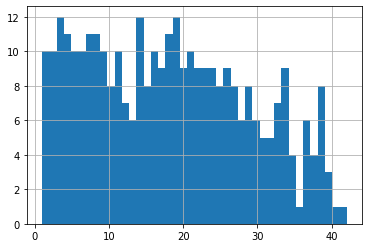

In [109]:
tmk_df["Shirt number"].hist(bins=42)

## 3. Data Preperation

## 4. Modelling

## 5. Evaluation

## 6. Deployment